# SBR 분석 시나리오 

Python 데이터 분석에서 가장 널리 쓰이는 Pandas를 기준으로.

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

#### 대용량 데이터 로딩

In [2]:
df = pd.read_pickle("~/Downloads/SBR_df_nan_converted.pickle", compression='zip')

#### 데이터 요약

In [3]:
df.head

<bound method NDFrame.head of          시도코드  시군구코드      등록일자      개업일자  폐업일자 폐업여부  활동구분  br사업체매출액  br사업체종사자  \
0          39  39010  20071207  20071128    -1    N     1       126         0   
1          39  39010  20071210  20071130    -1    N     1        63         0   
2          39  39010  20071231  20071231    -1    N     1       415         5   
3          39  39010  20080121  20080120    -1    N     1        64         0   
4          39  39010  20080124  20080113    -1    N     1         2         0   
...       ...    ...       ...       ...   ...  ...   ...       ...       ...   
9096317    22  22040  20000329  20000331    -1    N     1        46         0   
9096318    22  22040  20110729  20110804    -1    N     1       203         2   
9096319    22  22040  20140205  20131103    -1    N     1       121         0   
9096320    22  22040  20140717  20140724    -1    N     1         1         0   
9096321    22  22040  20180220  20180324    -1    N     1      1264        10  

#### 결손값 보정 등 임의 적용 

In [4]:
subset = df['br사업체종사자']

#### 데모를 위해 일부만 추출

In [5]:
var = subset.sort_values(ascending=False).iloc[:16384]

#### 자료의 히스토그램 분포

Text(0.5, 0, 'log10(#)')

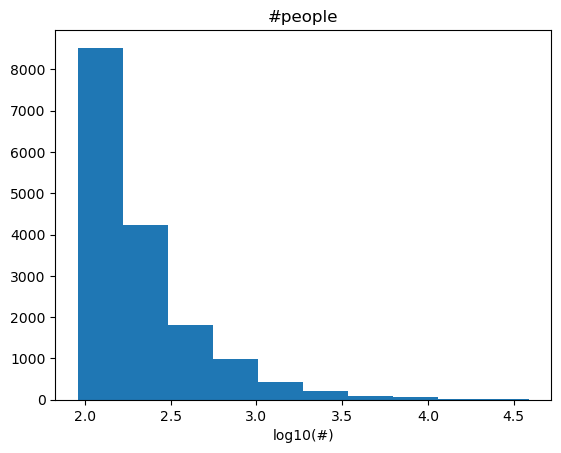

In [6]:
fig, ax = plt.subplots()
ax.hist(np.log10(var))
ax.set_title("#people")
ax.set_xlabel("log10(#)")

# 분산 계산 예제

$$ S^2 = \frac{\Sigma(x_i - \bar{x})^2}{n} $$


### 개발중인 FHE 통계 연산 라이브러리 hemul

In [7]:
from hemul.context import set_all
from hemul.container import CtxtFrame

binding to HEAAN


### 사용자 설정

필수적으로 필요한 정보를 입력 받음.  
1. 추후 컴파일러로 최적 파라미터를 자동 제안 예정
2. 별도의 config 파일 등 사용자 친화적 인터페이스 고려 중

In [8]:
# FHE 필수 정보
logp = 30
logq = 600
logn = 14
(context, ev, encoder, encryptor, decryptor) = set_all(logp, logq, logn)
server_agents = {"evaluator":ev, "encoder":encoder, "encryptor":encryptor}

FHE context is set


#### 암호화된 데이터를 위한 container에 암호문 추가

In [9]:
ctf = CtxtFrame(server_agents)

ctxt = encryptor.encrypt(var)

ctf.add_column("people", ctxt)

#### 복호화 전에는 값 출력 불가

In [10]:
print(ctf['people'])

You can't read the content


#### Client가 복호화하면 출력 가능 

* 본 데모에서 server / client의 구분은 없음. 

In [11]:
out = decryptor.decrypt(ctf['people'])
print(out)

[38604.00344392 38604.00331953 38604.00117963 ...    91.00249264
    91.00262815    91.00342382]


#### 복호화 결과는 최초 값과 매우 가까움
(동형암호 연산에 의한 미세한 오차 발생)

In [12]:
print("Are the values same?", var.values == out)
print("Are the values very close?", np.all(np.isclose(var, out, rtol=1e-4)))

Are the values same? [False False False ... False False False]
Are the values very close? True


#### 기초 통계값 중 하나인 분산 (variance 계산)

pandas의 API는 데이터 container가 고정적이며, 미리 준비된 method를 데이터에 적용하는 방식.  
Packing 이후 형태가 고정되는 동형암호 데이터 역시 pandas와 유사한 접근법이 유리  

In [13]:
# FHE 결과
result = ctf['people'].var()
output = decryptor.decrypt(result)[0]

print(output)

1625017.2437663516


In [14]:
# Pandas 정답
var.var()

1624775.2747835738

계산 결과 일치  

var() 계산은 다음 예제로 이어짐